# Study CebraSpike

In [12]:
%load_ext autoreload
%autoreload 2
import os
import torch
import numpy as np
from matplotlib import pyplot as plt
import cebra

# set project path
proj_path = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(proj_path)

from src.nodes.utils import get_config
from src.nodes.models.Flc import dataloader as flc_dataloader
from src.nodes.models.CebraSpike import dataloader as cs_dataloader
from src.nodes.models.Flc.models import FlcModel # FLC model
from src.nodes.models.CebraSpike.models import CebraSpike # FLC model
from src.nodes import utils 

# npx spont. biophy.
cfg_ns, _ = get_config("silico_neuropixels", "concatenated").values()
KS4_ns_10m = cfg_ns["sorting"]["sorters"]["kilosort4"]["10m"][
    "output"
]  # sorting with KS4
GT_ns_10m = cfg_ns["sorting"]["simulation"]["ground_truth"]["10m"]["output"] # KS4 sorting
STUDY_ns = cfg_ns["postprocessing"]["waveform"]["sorted"]["study"]["kilosort4"][
    "10m"
]  # WaveformExtractor
STUDY_ns_su = '/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/postpro/realism/spike/sorted/study_ks4_10m_single_units'

# npx evoked biophy.
cfg_ne, _ = get_config("silico_neuropixels", "stimulus").values()
KS4_ne_10m = cfg_ne["sorting"]["sorters"]["kilosort4"]["10m"]["output"]
GT_ne_10m = cfg_ne["sorting"]["simulation"]["ground_truth"]["10m"]["output"]
STUDY_ne = cfg_ne["postprocessing"]["waveform"]["sorted"]["study"]["kilosort4"][
    "10m"
]  # WaveformExtractor
STUDY_ne_su = '/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/postpro/realism/spike/sorted/study_ks4_10m_single_units'


# PATHS

# pre-computed sorted unit quality
quality_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/analysis/sorting_quality/sorting_quality.csv"

# model save path
cs_model_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/analysis/sorting_quality/models/cebra/sf_40Khz/crossval_data"


# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.001}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-09-20 19:03:02,155 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-20 19:03:02,210 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-09-20 19:03:02,211 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-20 19:03:02,252 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Specs

In [2]:
# check for GPU
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("__Number CUDA Devices:", torch.cuda.device_count())
    print("__CUDA Device Name:", torch.cuda.get_device_name(0))
    print(
        "__CUDA Device Total Memory [GB]:",
        torch.cuda.get_device_properties(0).total_memory / 1e9,
    )

__CUDNN VERSION: 90100
__Number CUDA Devices: 4
__CUDA Device Name: Tesla V100-SXM2-16GB
__CUDA Device Total Memory [GB]: 16.935419904


## (28m)Evaluate

* load model takes 2 minutes

In [10]:
# set parameters
torch.manual_seed(0)  # ensure reproducibility

# load the dataset formatted for the model
data_cs = cs_dataloader.load_dataset(
    qpath=quality_path,
    sorting_path=KS4_ns_10m,
    sortingtrue_path=GT_ns_10m,
    study_path=STUDY_ns,
    study_singleu_path=STUDY_ns_su,
    exp="NS",
    sorter="KS4",
    n_site=384,
    num_spikes=25,
    interval_ms=3,
    downsampling=1,
    load_we_if_exists=True,
    load_amp_if_exists=True,
    load_qmetrics_if_exists=False,
)

# instantiate the model
csmodel = CebraSpike(
    cfg={
        "model_architecture": "offset10-model",  # receptive field of size 10
        "distance": "cosine",  # adapted to contrastive learning
        "batch_size": data_cs["dataset"]["data"].shape[1],  # full dataset
        "temperature_mode": "auto",
        "learning_rate": 0.001,
        "max_iterations": 100,
        "conditional": "time_delta",
        "time_offsets": 10,  # 10 timesteps (should be >= size of receptve fields)
        "output_dimension": 3,  # number of dimensions of the embedding
        "device": "cuda_if_available",
        "verbose": True,
    }
)

# train and evaluate with cross-validation
cs_results = csmodel.evaluate(
    data_cs["dataset"], cs_model_path, is_train=True, seeds=np.arange(0, 100, 1)
)
display(cs_results["metric_stats"])

2024-09-20 18:30:12,074 - root - dataloader.py - load_dataset - INFO - Starting loading dataset..
2024-09-20 18:30:12,076 - root - dataloader.py - load_dataset - INFO - Computing sorted unit quality metrics..


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/cebraspike3/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/cebraspike3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/cebraspike3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/cebraspike3/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator IncrementalPCA from version 1.4.2 when using version 1.5.2. This might lead to breaking co

  0%|          | 0/184 [00:00<?, ?it/s]

****************** Analysing data completion ***************
quality metrics are: Index(['amplitude_cutoff', 'firing_range', 'firing_rate',
       'isi_violations_ratio', 'presence_ratio', 'rp_contamination',
       'rp_violations', 'sd_ratio', 'snr', 'silhouette', 'mad_ratio'],
      dtype='object')
Data completion: amplitude_cutoff        184
firing_range            184
firing_rate             184
isi_violations_ratio    184
presence_ratio          184
rp_contamination        184
rp_violations           184
sd_ratio                184
snr                     184
silhouette              182
mad_ratio               184
dtype: int64
Dropping units with missing metrics...
nb of units before curation: 184
nb of units after curation: 182
2024-09-20 18:30:58,887 - root - dataloader.py - load_dataset - INFO - Computed quality metrics
Recording sampling frequency: 40000.0
ex. dataset shape (L4): (26, 6000)
ex. label shape (L4): (26,)

unit sample size:

L1:  1 units
L23:  2 units
L4:  26 unit

pos: -1.1003 neg:  9.2167 total:  8.1164 temperature:  0.9072: 100%|██████████| 100/100 [00:16<00:00,  5.97it/s]
pos: -1.1014 neg:  9.2185 total:  8.1171 temperature:  0.9061: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]
pos: -1.1010 neg:  9.2168 total:  8.1158 temperature:  0.9069: 100%|██████████| 100/100 [00:16<00:00,  5.97it/s]
pos: -1.1002 neg:  9.2169 total:  8.1167 temperature:  0.9075: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]
pos: -1.0967 neg:  9.2130 total:  8.1164 temperature:  0.9102: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]
pos: -1.0967 neg:  9.2138 total:  8.1171 temperature:  0.9099: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]
pos: -1.0896 neg:  9.2076 total:  8.1180 temperature:  0.9153: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]
pos: -1.1023 neg:  9.2178 total:  8.1155 temperature:  0.9059: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]
pos: -1.1019 neg:  9.2178 total:  8.1159 temperature:  0.9055: 100%|██████████| 100/100 [00:17<0

{'precision_median': 0.6172161172161172,
 'precision_std': 0.13845072320134194,
 'precision_ci95': 0.027136341747463023,
 'recall_median': 0.7647058823529411,
 'recall_std': 0.17970660440790723,
 'recall_ci95': 0.035222494463949816}

## Plot losses

* note: you can load the cross-validation data and models from "cs_model_path".
* observations: loss do not converge for a few folds (2 or 3) for 50 iterations (14 mins duration).

In [18]:
grays

array([0.        , 0.12384917, 0.16971683, 0.204064  , 0.23257162,
       0.25739893, 0.2796393 , 0.29993598, 0.31870475, 0.3362325 ,
       0.35272687, 0.36834383, 0.38320399, 0.39740285, 0.41101757,
       0.42411148, 0.43673737, 0.44893975, 0.46075654, 0.47222038,
       0.48335962, 0.494199  , 0.50476034, 0.51506293, 0.52512397,
       0.53495884, 0.54458139, 0.55400411, 0.56323833, 0.57229435,
       0.58118159, 0.58990866, 0.59848349, 0.60691337, 0.61520502,
       0.6233647 , 0.63139817, 0.63931083, 0.64710767, 0.65479338,
       0.66237233, 0.66984862, 0.67722609, 0.68450836, 0.69169882,
       0.69880069, 0.70581699, 0.71275057, 0.71960414, 0.72638027,
       0.73308138, 0.73970977, 0.74626765, 0.75275709, 0.75918008,
       0.76553851, 0.77183419, 0.77806885, 0.78424412, 0.79036159,
       0.79642276, 0.80242907, 0.80838191, 0.81428261, 0.82013244,
       0.82593262, 0.83168433, 0.8373887 , 0.84304681, 0.84865972,
       0.85422843, 0.85975391, 0.86523711, 0.87067892, 0.87608

/tmp/ipykernel_83360/144445885.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1, 1), frameon=False)


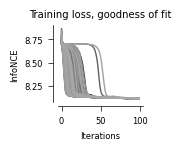

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(1.1, 1))

gamma = 2.2  # common value for gamma correction
grays = np.linspace(0, 0.4, len(cs_results["metric_data"])) ** (1 / gamma)


for f_ix in range(len(cs_results["metric_data"])):

    # plot training convergence
    ax = cebra.plot_loss(
        cs_results["metric_data"][f_ix]["model"]["model"], color=str(grays[f_ix]), ax=ax
    )

    # legend
    ax.legend(bbox_to_anchor=(1, 1), frameon=False)
    ax.set_title("Training loss, goodness of fit")
    ax.spines[["right", "top"]].set_visible(False)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("InfoNCE")

    # disconnect axes (R style)
    ax.spines[["right", "top"]].set_visible(False)
    ax.spines["bottom"].set_position(("axes", -0.05))
    ax.yaxis.set_ticks_position("left")
    ax.spines["left"].set_position(("axes", -0.05))
    ax.spines["right"].set_visible(False)

# save fig
utils.savefig("figures/1_sorting_quality/cebraspike/assets/fig5E_loss_gof.svg")